# Turbulent Pipe Flow (Reynolds 180)

The simulation of a periodic turbulent pipe flow is used for the validation of the immersed boundary method effectiveness to delineate a curved boundary in a turbulent flow. 
As for the turbulent channel case, the external force density term represents the pressure gradient $F_{x}=-\mathrm{d}p/\mathrm{d}x$, the regularized no-slip BC is employed at $y=0$ and $y=H$, and periodicity is considered in the remaining boundaries. 

> **_Note:_**
    A precursor turbulent flow is used to start the simulation and assure a turbulent flow. 
    This field can be generated through a precursor poiseuille flow simulation with an Lagrangian body  placed to generate perturbations and removed after turbulence is generated.

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/05_turbulent_pipe_flow.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

An extra spacing of 2 lattices at each side of the cylinder is kept to assure a complete interpolation-spread procedure.

In [2]:
sim_cfg = next(iter(sim_cfgs.values()))

Functions used for processing of turbulent pipe

In [3]:
from nassu.cfg.schemes.simul import SimulationConfigs
import numpy as np

from vtk.util.numpy_support import vtk_to_numpy
from tests.validation.notebooks import common

stats_export = sim_cfg.output.stats["default"]
last_step = stats_export.interval.get_all_process_steps(sim_cfg.n_steps)[-1]
reader = stats_export.read_vtm_export(last_step)
reader_output = reader.GetOutput()


def get_macr_compressed(
    sim_cfg: SimulationConfigs, macr_name: str, is_2nd_order: bool
) -> tuple[np.ndarray, np.ndarray]:
    global reader, reader_output

    macr_name_read = macr_name if not is_2nd_order else f"{macr_name}_2nd"
    ds = sim_cfg.domain.domain_size

    p0 = np.array((ds.x // 2, 0, ds.z // 2))
    p1 = np.array((ds.x // 2, ds.y - 1, ds.z // 2))
    n_points = ds.y
    pos = np.linspace(p0, p1, num=n_points, endpoint=True)
    norm_pos = (pos[:, 1] + 0.5) / (len(pos) + 1)

    # Sum 0.5 because data is cell centered in vtm
    line = common.create_line(p0 + 0.5, p1 + 0.5, n_points - 1)

    probe_filter = common.probe_over_line(line, reader_output)
    probed_data = vtk_to_numpy(probe_filter.GetOutput().GetPointData().GetArray(macr_name_read))

    return norm_pos, probed_data

## Results

Load values for comparison

In [4]:
import pandas as pd
import numpy as np
import os

comparison_folder = "tests/validation/comparison/Turbulent_pipe/Re_tau=180"
files = ["ux_avg", "uang_rms", "ur_rms", "ux_rms"]
get_filename_csv = lambda f: os.path.join(comparison_folder, f + ".csv")


df_cp = {f: pd.read_csv(get_filename_csv(f), delimiter=",") for f in files}

Friction velocity and y+ to use

In [5]:
yp = 2.5
u_fric = 0.003401361 * 0.925

Load simulation velocity fields

In [6]:
pos, ux_avg = get_macr_compressed(sim_cfg, "ux", is_2nd_order=False)
pos, ux_2nd = get_macr_compressed(sim_cfg, "ux", is_2nd_order=True)
ux_rms = (ux_2nd - ux_avg**2) ** 0.5

pos, uy_avg = get_macr_compressed(sim_cfg, "uy", is_2nd_order=False)
pos, uy_2nd = get_macr_compressed(sim_cfg, "uy", is_2nd_order=True)
uy_rms = (uy_2nd - uy_avg**2) ** 0.5

pos, uz_avg = get_macr_compressed(sim_cfg, "uz", is_2nd_order=False)
pos, uz_2nd = get_macr_compressed(sim_cfg, "uz", is_2nd_order=True)
uz_rms = (uz_2nd - uz_avg**2) ** 0.5

ux_avg.shape, ux_rms.shape

((152,), (152,))

In [7]:
wall_pos = 5  # From 4 to 148
mid_pos = ux_avg.shape[0] // 2

ux_vals = ux_avg[wall_pos:mid_pos] / u_fric
x_vals = np.arange(len(ux_vals)) * yp

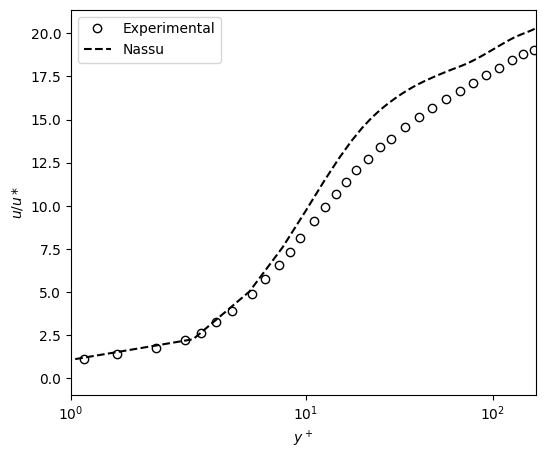

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

ax.plot(df_cp["ux_avg"]["y+"], df_cp["ux_avg"]["u/u*"], "ko", fillstyle="none")
ax.plot(x_vals, ux_vals, "k--")
ax.legend(["Experimental", "Nassu"])

ax.set_xscale("symlog")
ax.set_xlim((1, 170))

ax.set_ylabel("$u/u*$")
ax.set_xlabel("$y^+$")

plt.show(fig)

The average flow velocity shown below presents an excellent agreement with experimental results. Below, the root mean squared velocity $u_{\alpha,\mathrm{rms}}$ is also presented against experimental data.

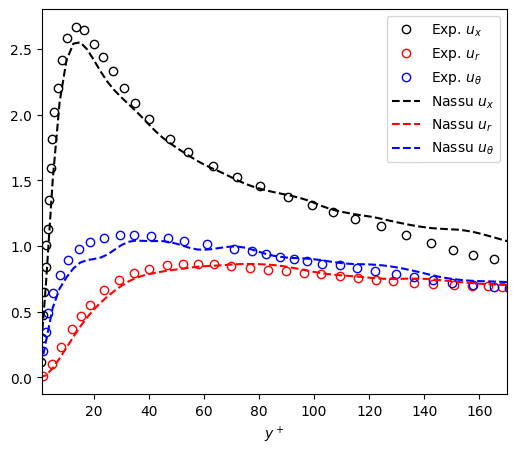

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

get_prof_plot = lambda arr: arr[wall_pos:mid_pos] / u_fric

ax.plot(df_cp["ux_rms"]["y+"], df_cp["ux_rms"]["u/u*"], "ko", fillstyle="none")
ax.plot(df_cp["ur_rms"]["y+"], df_cp["ur_rms"]["u/u*"], "ro", fillstyle="none")
ax.plot(df_cp["uang_rms"]["y+"], df_cp["uang_rms"]["u/u*"], "bo", fillstyle="none")
ax.plot(x_vals, get_prof_plot(ux_rms), "k--")
ax.plot(x_vals, get_prof_plot(uy_rms), "r--")
ax.plot(x_vals, get_prof_plot(uz_rms), "b--")
ax.legend(
    [
        r"Exp. $u_x$",
        r"Exp. $u_r$",
        r"Exp. $u_{\theta}$",
        r"Nassu $u_x$",
        r"Nassu $u_r$",
        r"Nassu $u_{\theta}$",
    ]
)

ax.set_xlim((1, 170))

ax.set_xlabel("$y^+$")

plt.show(fig)

Also, an excellement agreeement is obtained for all directions in cylindrical coordinates. In general the results confirm the solver capability of solving a pipe flow turbulence, confirming the IBM as adequate to represent a curved boundary and the D3Q27 velocity set as capable of axissymetric turbulence.

## Version

In [10]:
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: 09c9337ca174e12ce2cfa6eb39867054691a2742


## Configuration

In [11]:
from IPython.display import Code

Code(filename=filename)

simulations:
  - name: periodicTurbulentPipe
    save_path: ./tests/validation/results/05_turbulent_pipe_flow/periodic

    n_steps: 400000
    # u* = 0.0034013 / R = 72 / ETT = R/u* = 18,820
    # Re_tau = 180
    # y+ = 2.5

    report:
      frequency: 1000

    domain:
      domain_size:
        x: 456
        y: 152
        z: 152
      block_size: 8
      bodies:
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          transformation:
            scale: [72, 72, 72]
            translation: [-4, 4, 4]

    data:
      divergence: { frequency: 50 }
      instantaneous:
        default: { interval: { frequency: 200000 }, macrs: [rho, u] }
      statistics:
        interval: { frequency: 100, start_step: 200000 }
        macrs_1st_order: [rho, u]
        macrs_2nd_order: [u]
        exports:
          default: { interval: { frequency: 50000 } }

    models:
      precision:
        default: single

      LBM:
        tau: 0.504081632653061
        F:
          x: 3.21368E-07
          y: 0
          z: 0
        vel_set: D3Q27
        coll_oper: RRBGK
      initialization:
        vtm_filename: "../nassuArtifacts/macrs/turbulent_pipe.vtm"

      engine:
        name: CUDA

      BC:
        periodic_dims: [true, false, false]
        BC_map:
          - pos: N
            BC: RegularizedHWBB
            wall_normal: N
            order: 1

          - pos: S
            BC: RegularizedHWBB
            wall_normal: S
            order: 1

          - pos: F
            BC: RegularizedHWBB
            wall_normal: F
            order: 2

          - pos: B
            BC: RegularizedHWBB
            wall_normal: B
            order: 2

      IBM:
        forces_accomodate_time: 1000
        body_cfgs:
          default: {}